# Hainich with ERA-Interim
> Manual fine tuning learning process for presentation 18 Jan 2023

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from meteo_imp.kalman.fastai import *
from meteo_imp.kalman.filter import *
from meteo_imp.utils import *
from meteo_imp.data import  *
from meteo_imp.data import  _def_meteo_vars, units

from fastai.tabular.learner import *
from fastai.learner import *
from fastai.callback.all import *
from fastcore.foundation import L

from meteo_imp.kalman.fastai import show_results
import pandas as pd
import numpy as np
import torch
from pyprojroot import here

from sklearn.decomposition import PCA

In [ ]:
base_dir = here("analysis/presentations/plots_18_jan")
base_dir.mkdir(exist_ok=True)

In [ ]:
def save_plot(p, path):
    f_name = base_dir / (path + ".vl.json")
    with open(f_name, 'w') as f:
        f.write(p.to_json())
    return f_name

In [ ]:
reset_seed()

In [ ]:
hai = pd.read_parquet(hai_path64)
hai_era = pd.read_parquet(hai_era_path64)

### PCA

In [ ]:
pc = PCA().fit(hai)

In [ ]:
d0 = hai.iloc[0:1]

In [ ]:
tr0 = pc.transform(d0)

In [ ]:
tr0

array([[-121.11917652,   -7.06844313,    0.87975241]])

In [ ]:
t0 = np.random.randn(5,1) * 10
tt = np.hstack([t0, 2 * t0 + np.random.randn(5,1), 3 * t0 + np.random.randn(5,1)])

In [ ]:
tt = np.vstack([tt, -tt])

In [ ]:
tt.mean(0)

array([1.77635684e-16, 0.00000000e+00, 0.00000000e+00])

In [ ]:
def pca(X):
    # Data matrix X, assumes 0-centered
    n, m = X.shape
    assert np.allclose(X.mean(axis=0), np.zeros(m))
    # Compute covariance matrix
    C = np.dot(X.T, X) / (n-1)
    # Eigen decomposition
    eigen_vals, eigen_vecs = np.linalg.eig(C)
    # Project X onto PC space
    X_pca = np.dot(X, eigen_vecs)
    return X_pca, eigen_vecs

In [ ]:
pca(tt)

(array([[-9.15947487e+00, -3.03773243e-01,  3.81626348e-01],
        [ 2.00045215e+01, -1.99595583e-02,  1.53745860e+00],
        [ 1.33744310e+01,  2.01395206e-02, -3.19819214e-02],
        [-8.99057811e+00,  1.24208069e-01,  9.57988123e-01],
        [ 3.14616875e+01, -4.88141095e-02, -5.79117681e-01],
        [ 9.15947487e+00,  3.03773243e-01, -3.81626348e-01],
        [-2.00045215e+01,  1.99595583e-02, -1.53745860e+00],
        [-1.33744310e+01, -2.01395206e-02,  3.19819214e-02],
        [ 8.99057811e+00, -1.24208069e-01, -9.57988123e-01],
        [-3.14616875e+01,  4.88141095e-02,  5.79117681e-01]]),
 array([[-0.26545847, -0.95659856,  0.12021234],
        [-0.53518386,  0.04249433, -0.84366608],
        [-0.80194142,  0.28829401,  0.52323659]]))

In [ ]:
sk_pc = PCA(2).fit(tt)

In [ ]:
tt @ sk_pc.components_.T

array([[ -9.15947487,   0.38162635],
       [ 20.00452148,   1.5374586 ],
       [ 13.37443103,  -0.03198192],
       [ -8.99057811,   0.95798812],
       [ 31.46168754,  -0.57911768],
       [  9.15947487,  -0.38162635],
       [-20.00452148,  -1.5374586 ],
       [-13.37443103,   0.03198192],
       [  8.99057811,  -0.95798812],
       [-31.46168754,   0.57911768]])

In [ ]:
tr = sk_pc.transform(tt)
tr

array([[ -9.15947487,   0.38162635],
       [ 20.00452148,   1.5374586 ],
       [ 13.37443103,  -0.03198192],
       [ -8.99057811,   0.95798812],
       [ 31.46168754,  -0.57911768],
       [  9.15947487,  -0.38162635],
       [-20.00452148,  -1.5374586 ],
       [-13.37443103,   0.03198192],
       [  8.99057811,  -0.95798812],
       [-31.46168754,   0.57911768]])

In [ ]:
sk_pc.components_.T

array([[-0.26545847,  0.12021234],
       [-0.53518386, -0.84366608],
       [-0.80194142,  0.52323659]])

In [ ]:
(sk_pc.components_ @ tt.T).T

array([[ -9.15947487,   0.38162635],
       [ 20.00452148,   1.5374586 ],
       [ 13.37443103,  -0.03198192],
       [ -8.99057811,   0.95798812],
       [ 31.46168754,  -0.57911768],
       [  9.15947487,  -0.38162635],
       [-20.00452148,  -1.5374586 ],
       [-13.37443103,   0.03198192],
       [  8.99057811,  -0.95798812],
       [-31.46168754,   0.57911768]])

In [ ]:
tt[0, None]

array([[2.76792539, 4.56712931, 7.45746711]])

In [ ]:
sk_pc.components_.shape

(3, 3)

In [ ]:
tt[0].shape

(3,)

In [ ]:
(sk_pc.components_ @ tt[0])

array([-9.15947487,  0.38162635])

In [ ]:
tt[0]

array([2.76792539, 4.56712931, 7.45746711])

In [ ]:
sk_pc.components_.T @ tr[0]

array([2.47733634, 4.58003795, 7.54504311])

In [ ]:
sk_pc.inverse_transform(tr[0])

array([2.47733634, 4.58003795, 7.54504311])

In [ ]:
d0.to_numpy()

array([[-0.6  ,  0.   ,  0.222]])

In [ ]:
hai.iloc[0]

TA      -0.600
SW_IN    0.000
VPD      0.222
Name: 2000-01-01 00:30:00, dtype: float64

$$ x = y\Lambda $$

In [ ]:
pc.components_

array([[ 0.01681572,  0.99979324,  0.01143269],
       [ 0.93010891, -0.01983747,  0.36674772],
       [-0.36689868, -0.00446652,  0.93025018]])

In [ ]:
np.linalg.inv(pc.components_)

array([[ 0.01681572,  0.93010891, -0.36689868],
       [ 0.99979324, -0.01983747, -0.00446652],
       [ 0.01143269,  0.36674772,  0.93025018]])

## Setup

assuming that the control has the same dimensions of the observations then if we are doing a local slope model we have $B \in \mathbb{R}^{state \times contr}$:
$$ B = \begin{bmatrix} -I & I \\ 0 & 0 \end{bmatrix}$$

In [ ]:
from torch import hstack, eye, vstack, ones, zeros, tensor
from functools import partial

In [ ]:
def set_dtype(*args, dtype=torch.float64):
    return [partial(arg, dtype=dtype) for arg in args] 

In [ ]:
eye, ones, zeros, tensor = set_dtype(eye, ones, zeros, tensor)

In [ ]:
def init_smart(n_dim_obs, n_dim_state, df, pca=True):
    # n_dim_obs == n_dim_contr
    if pca:
        comp = PCA(n_dim_state).fit(df).components_
        obs_matrix = tensor(comp.T) # transform state -> obs
        contr_matrix = tensor(comp) # transform obs -> state
    else:
        obs_matrix, contr_matrix = eye(n_dim_obs), eye(n_dim_obs)
        
    return KalmanFilter(
        trans_matrix =     vstack([hstack([eye(n_dim_state),                eye(n_dim_state)]),
                                   hstack([zeros(n_dim_state, n_dim_state), eye(n_dim_state)])]),
        trans_off =        zeros(n_dim_state * 2),        
        trans_cov =        eye(n_dim_state * 2)*.1,        
        obs_matrix =       hstack([obs_matrix, zeros(n_dim_obs, n_dim_state)]),
        obs_off =          zeros(n_dim_obs),          
        obs_cov =          eye(n_dim_obs)*.01,            
        contr_matrix =     vstack([hstack([-contr_matrix,                  contr_matrix]),
                                   hstack([ zeros(n_dim_state,n_dim_obs), zeros(n_dim_state, n_dim_obs)])]),
        init_state_mean =  zeros(n_dim_state * 2),        
        init_state_cov =   eye(n_dim_state * 2) * 3,
    ) 

In [ ]:
np.hstack([np.eye(2), np.eye(2)])

array([[1., 0., 1., 0.],
       [0., 1., 0., 1.]])

In [ ]:
init_smart(3,2, hai)

Kalman Filter
        N dim obs: 3, N dim state: 4, N dim contr: 6

In [ ]:
class PersistentRecorder(Callback):
    order = 70
    name = "per_recorder"
    attrs = ['lrs', 'iters', 'losses', 'values']
    def before_fit(self):
        "Prepare state for training"
        for attr in self.attrs:
            if not hasattr(self.per_recorder, attr): setattr(self.per_recorder, attr, [])

    def after_batch(self):
        for attr in self.attrs:
            setattr(self.per_recorder, attr, getattr(self.recorder, attr))

In [ ]:
models = []

In [ ]:
dls = imp_dataloader(hai, hai_era, var_sel = ['TA', 'SW_IN', 'VPD'], block_len=200, gap_len=10, bs=20, control_lags=[1], n_rep=2)

In [ ]:
len(dls.valid.items)
items = [dls.valid.items[i] for i in [10, 50, 100, 200, 300, 400]]

In [ ]:
def train_show_save(learn, n_iter, lr):
    learn.fit(n_iter, lr)
    models.append(learn.model.state_dict().copy())
    learn.recorder.plot_loss()
    items = [learn.dls.valid.items[i] for i in [10, 50, 100, 200, 300, 400]]
    return show_results(learn, items = items, control=hai_control)

## Gaps all variables

In [ ]:
model = init_smart(3,3, hai, pca=False).cuda()
model.var_names = _def_meteo_vars.values()

In [ ]:
loss = loss_func=KalmanLoss(only_gap=False)
learn = Learner(dls, model, loss, cbs=[Float64Callback], metrics=imp_metrics)

In [ ]:
learn.model.use_smooth = True

In [ ]:
show_results(learn, items=items, control=hai_control)

alt.HConcatChart(...)

alt.HConcatChart(...)

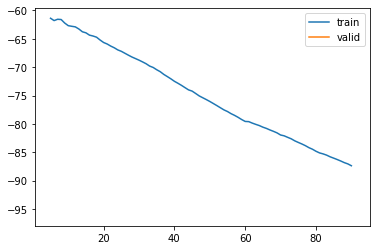

In [ ]:
train_show_save(learn, 1, 1e-3)

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (__class__) that exists in the learner. Use `self.learn.__class__` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


alt.HConcatChart(...)

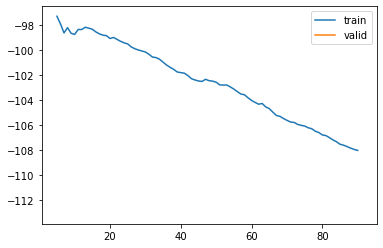

In [ ]:
train_show_save(learn, 1, 1e-3)

In [ ]:
# learn.save("17_jan_all_gaps")

Path('models/17_jan_all_gaps.pth')

In [ ]:
train_show_save(learn, 2, 1e-3)

alt.HConcatChart(...)

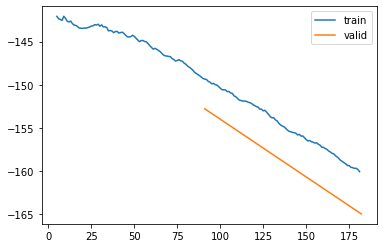

In [ ]:
train_show_save(learn, 2, 1e-3)

In [ ]:
# learn.save("17_jan_all_gaps_final")

Path('models/17_jan_all_gaps_final.pth')

### Results

In [ ]:
learn.load("17_jan_all_gaps_final");

In [ ]:
p = show_results(learn, control=hai_control, items = [items[i] for i in [0,5,4]], show_metric=False, units=list(units.values()))
p

alt.HConcatChart(...)

In [ ]:
p0 = show_results(learn, control=hai_control, items = [items[i] for i in [0]], n_cols=2, show_metric=False, props={'width': 350, 'height': 250},  units=list(units.values()))
p0

alt.HConcatChart(...)

In [ ]:
p1 = show_results(learn, control=hai_control, items = [items[i] for i in [5]], n_cols=2, show_metric=False, props={'width': 350, 'height': 250}, units=list(units.values()))
p1

alt.HConcatChart(...)

In [ ]:
p2 = show_results(learn, control=hai_control, items = [items[i] for i in [4]], n_cols=2, show_metric=False, props={'width': 350, 'height': 250}, units=list(units.values()))
p2

alt.HConcatChart(...)

In [ ]:
save_plot(p0, "results_gap_all_vars_g0")
save_plot(p1, "results_gap_all_vars_g1")
save_plot(p2, "results_gap_all_vars_g2")

Path('/home/simone/Documents/uni/Thesis/GPFA_imputation/analysis/presentations/plots_18_jan/results_gap_all_vars_g2.vl.json')

In [ ]:
interact_results(learn, hai, hai_era)

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (__class__) that exists in the learner. Use `self.learn.__class__` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


interactive(children=(IntSlider(value=10, description='gap_len', min=1), Text(value='10, 100', description='it…

<function meteo_imp.kalman.fastai.interact_results.<locals>._inner(gap_len, items_idx, control_lags, block_len, shift, **var_names)>

## Gap in only 1 variable

In [ ]:
dls2 = imp_dataloader(hai, hai_era, var_sel = ['TA'], block_len=200, gap_len=10, bs=20, control_lags=[1], n_rep=2)

In [ ]:
model2 = init_smart(3,3, hai, pca=True).cuda()

In [ ]:
model2

Kalman Filter
        N dim obs: 3, N dim state: 6, N dim contr: 6

In [ ]:
loss2 = loss_func=KalmanLoss(only_gap=False)
learn2 = Learner(dls2, model2, loss2, cbs=[Float64Callback], metrics=imp_metrics)

alt.HConcatChart(...)

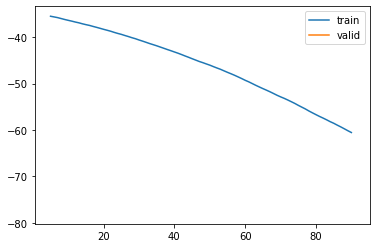

In [ ]:
train_show_save(learn2, 1, 1e-3)

alt.HConcatChart(...)

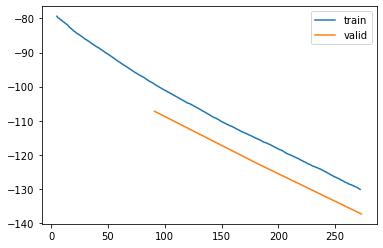

In [ ]:
train_show_save(learn2, 3, 1e-3)

In [ ]:
learn2.loss_func = KalmanLoss(only_gap=True)

alt.HConcatChart(...)

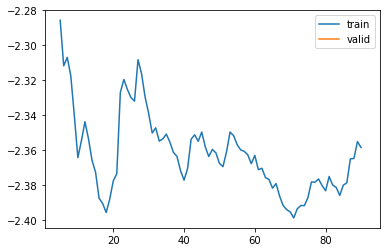

In [ ]:
train_show_save(learn2, 1, .5e-3)

alt.HConcatChart(...)

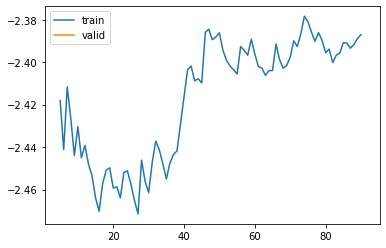

In [ ]:
train_show_save(learn2, 1, 2e-4)